In [1]:
import time
start_time=time.time()
from pathlib import Path
import sys
import json
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Add path to py_modules 
sys.path.append(str(Path().resolve().parents[1] / 'py_modules')) # 1 level up = project root

# Add path to pipeline_config.py
sys.path.append(str(Path().resolve().parents[0]))  # 1 level up = project root

# Import from pipeline_config and py_modules
from pipeline_config import OBSERVATIONS_DIR, MAPS_DIR

#from io_utils import load_fits
#import strucfunc
#from strucfunc import sosflog
#import bfuncx

In [3]:
# Input FITS files
name = 'Ar_III-7136'
name_export = name + '_mask'
flux_path    = OBSERVATIONS_DIR / f'linesum-{name}.fits'
radvel_path  = OBSERVATIONS_DIR / f'mean-{name}-patfixx-bin001.fits'

# Open files
flux    = fits.open(flux_path)
rad_vel = fits.open(radvel_path)

In [4]:
# Region propertires
dist   = 410   # distance [parsecs]
pix    = 0.2 # spatialscale [arcsec per pixel]

# Observation propertires
seeing = 0.9   # FWHM seeing [arcsec] 

# Conversions
pc = dist * ( 2 * np.pi ) / (360 * 60 * 60) # value in parsecs of each arcsec
s0 = (seeing  * pc) / 2.355 # RMS seeing [parsecs]
pc , s0

(0.0019877360925490972, 0.0007596443665792729)

In [5]:
flux.info()

Filename: C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse\observations\linesum-Ar_III-7136.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (1766, 1476)   float32   


In [6]:
rad_vel.info()

Filename: C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse\observations\mean-Ar_III-7136-patfixx-bin001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SCALED        1 ImageHDU        26   (1792, 1536)   float64   
  2  WEIGHT        1 ImageHDU        26   (1792, 1536)   float64   


In [7]:
sb = flux[0].data.astype(float)
vv = rad_vel[1].data.astype(float)

In [8]:
## Replace spurious values in the arrays
#m = ~np.isfinite(sb*vv) | (sb < 0.0)

#sb[m] = 0.0
#vv[m] = np.nanmean(vv)
#sb /= sb.max()

#good = (~m) & (sb > 0.001)

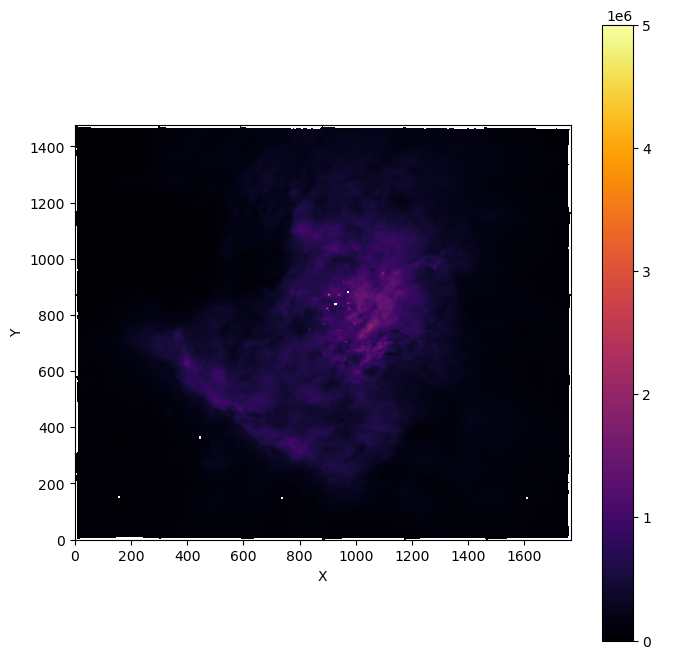

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb, cmap='inferno')

cbar = plt.colorbar()
plt.clim(0, 0.5e7)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

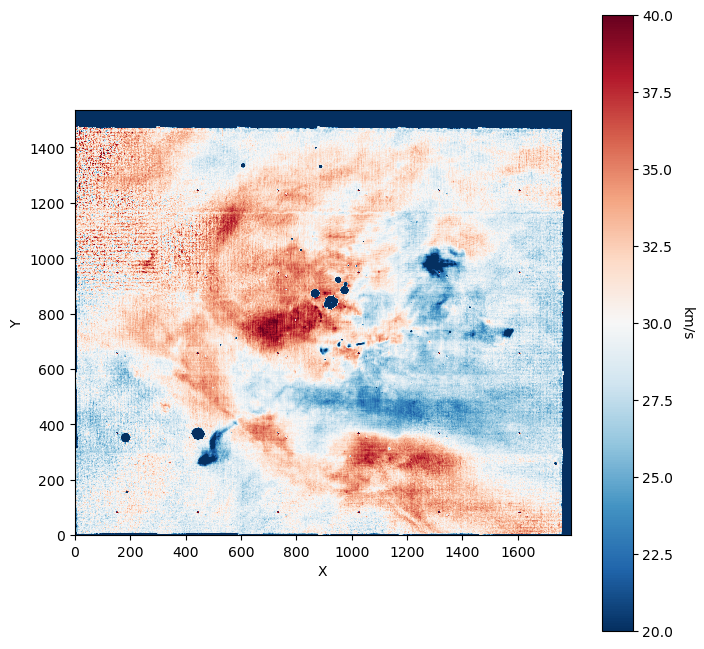

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(vv, cmap='RdBu_r')

cbar = plt.colorbar()
plt.clim(20,40)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [11]:
trim = (slice(0, 1476),slice(0, 1766))


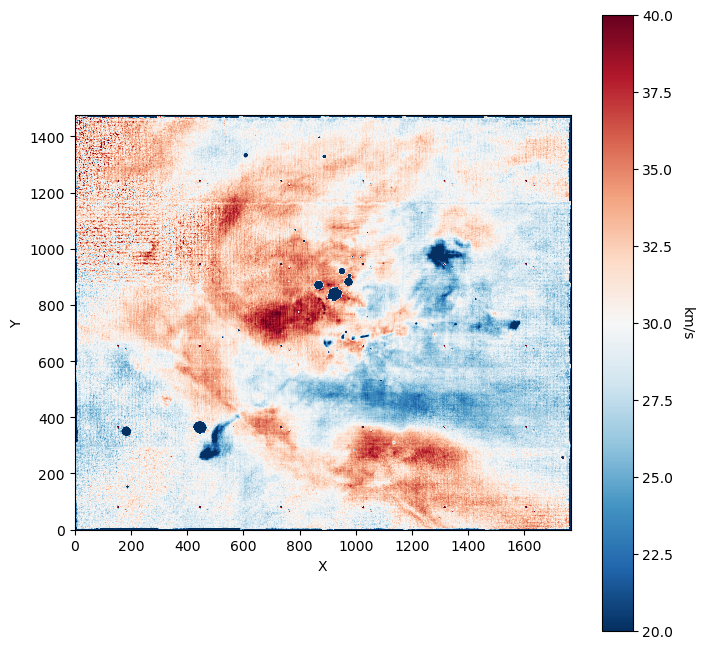

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(vv[trim], cmap='RdBu_r')

cbar = plt.colorbar()
plt.clim(20,40)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [13]:
vv = vv[trim]

## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

#good = (~m) & (sb > 0.001)

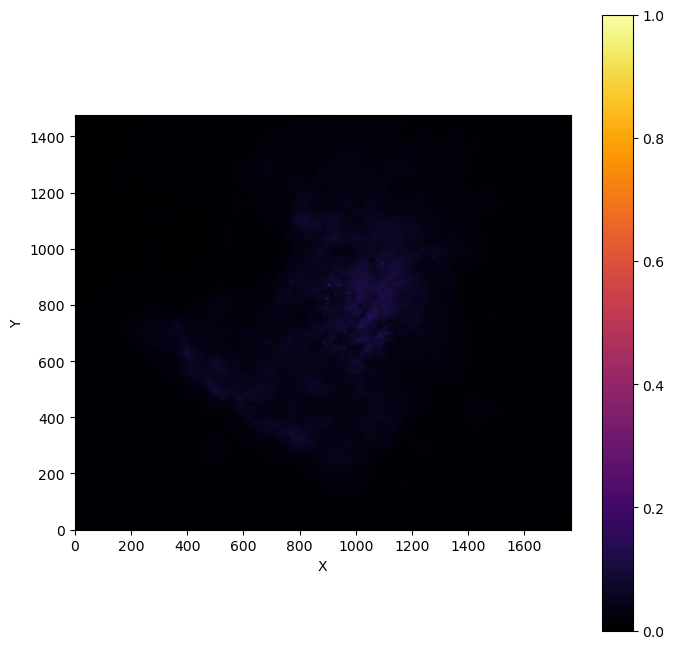

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb, cmap='inferno')

cbar = plt.colorbar()
#plt.clim(0, 1)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [15]:
sb_df       = pd.DataFrame(sb)
sb_df       = sb_df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'I'})

In [16]:
vv_df       = pd.DataFrame(vv)
data        = vv_df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'RV'})
data['I']   = sb_df.I

In [17]:
data.describe()

,X,Y,RV,I
count,2.606616e+06,2.606616e+06,2.606616e+06,2.606616e+06
mean,7.375000e+02,8.825000e+02,3.021132e+01,1.961079e-02
std,4.260845e+02,5.098003e+02,5.391218e+00,1.958229e-02
min,0.000000e+00,0.000000e+00,-1.591335e+03,0.000000e+00
25%,3.687500e+02,4.410000e+02,2.778565e+01,6.497584e-03
50%,7.375000e+02,8.825000e+02,3.020533e+01,1.127298e-02
75%,1.106250e+03,1.324000e+03,3.269925e+01,2.737519e-02
max,1.475000e+03,1.765000e+03,8.809617e+02,1.000000e+00


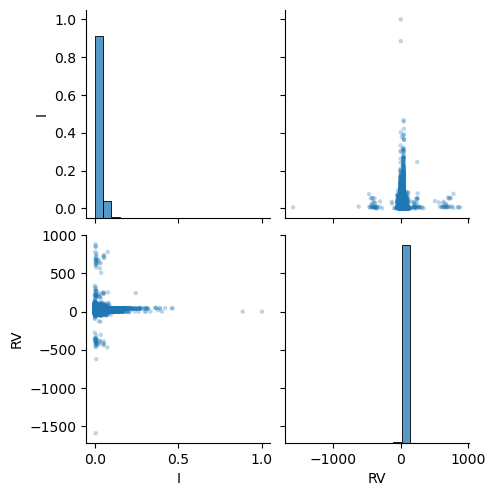

In [18]:
sns.pairplot(data, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

In [19]:
n = 2.5
mask = (data.I > 0.01)  &  (data.RV > data.RV.mean() - n*data.RV.std()) & (data.RV < data.RV.mean() + n*data.RV.std())

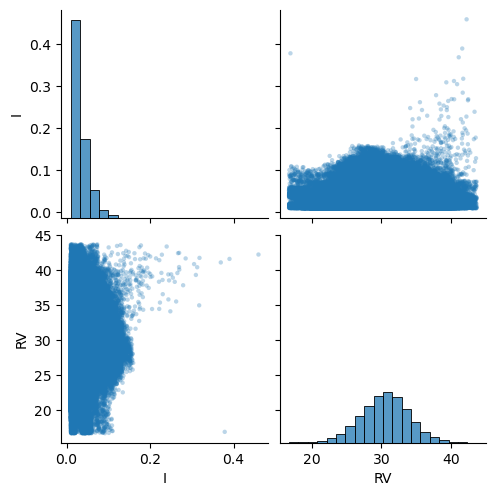

In [20]:
sns.pairplot(data[mask], 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

In [21]:
data[mask].describe()

,X,Y,RV,I
count,1.435134e+06,1.435134e+06,1.435134e+06,1.435134e+06
mean,7.981505e+02,9.535892e+02,3.049112e+01,3.060427e-02
std,3.775969e+02,3.417900e+02,3.460426e+00,2.017161e-02
min,4.000000e+00,7.500000e+01,1.673392e+01,1.000000e-02
25%,4.860000e+02,6.860000e+02,2.825104e+01,1.440585e-02
50%,7.660000e+02,9.630000e+02,3.058701e+01,2.441082e-02
75%,1.131000e+03,1.234000e+03,3.279497e+01,4.092867e-02
max,1.474000e+03,1.758000e+03,4.367748e+01,4.593459e-01


In [22]:
sb_mask = (data[mask].round(2)).pivot(index='Y', columns='X', values='I')
vv_mask = (data[mask].round(2)).pivot(index='Y', columns='X', values='RV')

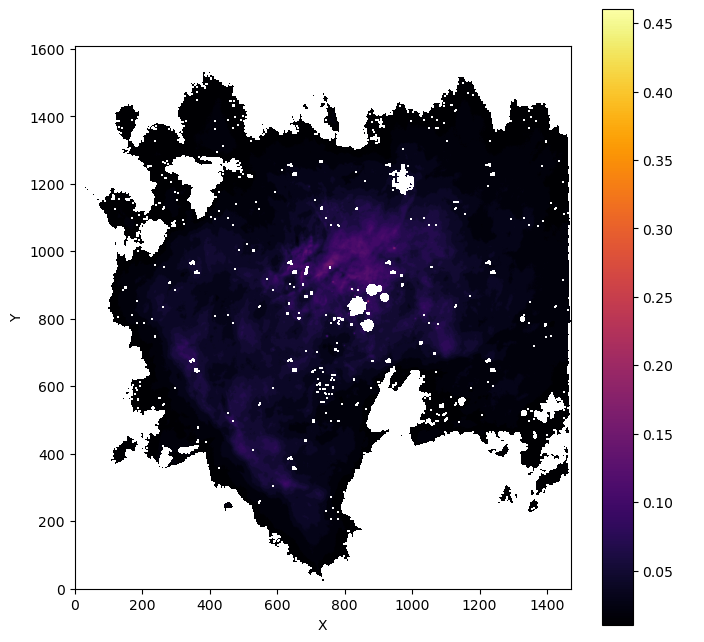

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb_mask, cmap='inferno')

cbar = plt.colorbar()
#plt.clim(0.001,1)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

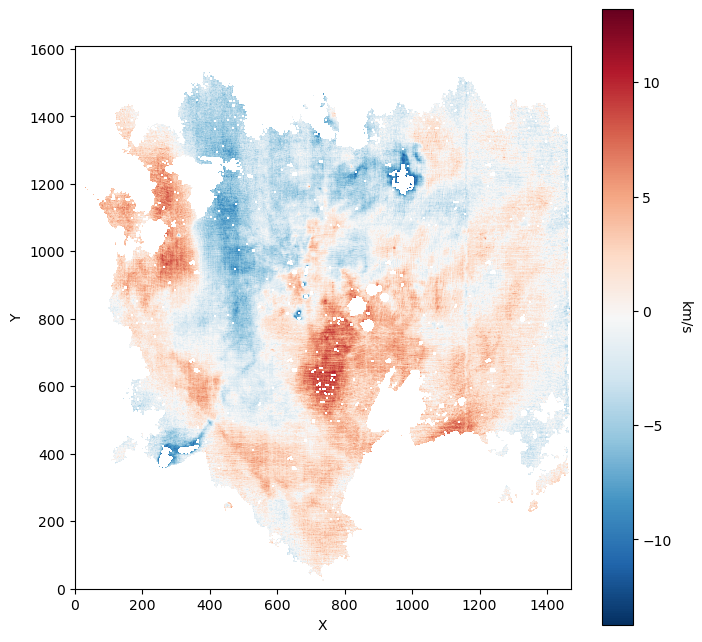

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(vv_mask-np.nanmean(vv_mask.to_numpy()), cmap='RdBu_r')

cbar = plt.colorbar()
#plt.clim(5,25)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

#plt.gcf().set_facecolor("limegreen")
plt.gca().invert_yaxis()

30.491119735160638

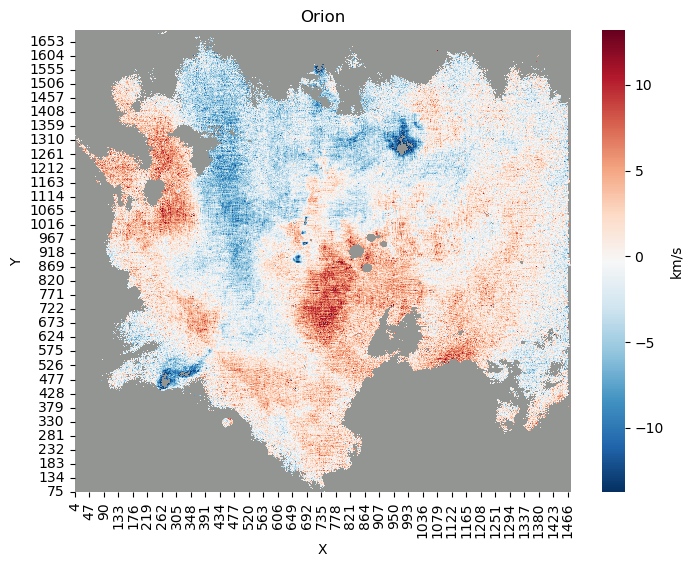

In [40]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot()

sns.heatmap(vv_mask-np.nanmean(vv_mask.to_numpy()), cmap="RdBu_r",cbar_kws={'label': 'km/s'})
plt.title('Orion')
ax.set_facecolor('xkcd:gray')
plt.gca().invert_yaxis()

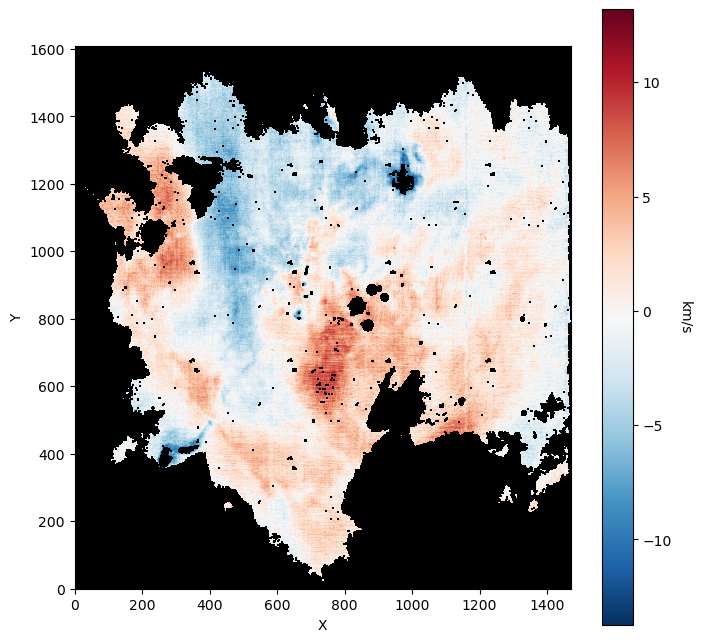

In [53]:
# Mask the zero or unwanted values
masked_vv = np.ma.masked_where(vv_mask == 0, vv_mask)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(masked_vv-np.nanmean(vv_mask.to_numpy()), cmap='RdBu_r')

# Set the background color for the masked areas
im.cmap.set_bad(color='black')  # This sets the background color

# Colorbar and other settings
cbar = fig.colorbar(im, ax=ax)
#im.set_clim(0, 20)
cbar.set_label('km/s', rotation=270, labelpad=15)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.invert_yaxis()
plt.show()